# **Technical Validations**

We here show how external validation can be performed. The internal validation results can be found as the objective values resulted from the optimization model.

## Read ACM PUMS

We read the ACS PUMS data and process the values of these characteristics to match those in the synthetic data.

In [5]:
import pandas as pd

filename_pums = "data/usa_pums.csv"
data_pums = pd.read_csv(filename_pums, encoding="ISO-8859-1")
data_pums['STATEFIP'] = data_pums['STATEFIP'].apply('{:0>2}'.format)
data_pums['PUMA'] = data_pums['PUMA'].apply('{:0>5}'.format)
data_pums['PUMAID'] = data_pums[['STATEFIP', 'PUMA']].apply(lambda x: ''.join(x), axis=1)
col_list = ["STATEFIP", "PUMA", "PUMAID", "GQ", "SEX", "AGE", "RACE", "HISPAN"]
data_pums = data_pums[col_list]

# GQ
data_pums.loc[(data_pums["GQ"] <= 2) | (data_pums["GQ"] >= 5), "GQ"] = 1
data_pums.loc[data_pums["GQ"] == 3, "GQ"] = 2
data_pums.loc[data_pums["GQ"] == 4, "GQ"] = 3

# AGE
data_pums.loc[data_pums["AGE"] < 5, "AGE"] = 1
data_pums.loc[(data_pums["AGE"] >= 5) & (data_pums["AGE"] <= 9), "AGE"] = 2
data_pums.loc[(data_pums["AGE"] >= 10) & (data_pums["AGE"] <= 14), "AGE"] = 3
data_pums.loc[(data_pums["AGE"] >= 15) & (data_pums["AGE"] <= 17), "AGE"] = 4
data_pums.loc[(data_pums["AGE"] >= 18) & (data_pums["AGE"] <= 19), "AGE"] = 5
data_pums.loc[data_pums["AGE"] == 20, "AGE"] = 6
data_pums.loc[data_pums["AGE"] == 21, "AGE"] = 7
data_pums.loc[(data_pums["AGE"] >= 22) & (data_pums["AGE"] <= 24), "AGE"] = 8
data_pums.loc[(data_pums["AGE"] >= 25) & (data_pums["AGE"] <= 29), "AGE"] = 9
data_pums.loc[(data_pums["AGE"] >= 30) & (data_pums["AGE"] <= 34), "AGE"] = 10
data_pums.loc[(data_pums["AGE"] >= 35) & (data_pums["AGE"] <= 39), "AGE"] = 11
data_pums.loc[(data_pums["AGE"] >= 40) & (data_pums["AGE"] <= 44), "AGE"] = 12
data_pums.loc[(data_pums["AGE"] >= 45) & (data_pums["AGE"] <= 49), "AGE"] = 13
data_pums.loc[(data_pums["AGE"] >= 50) & (data_pums["AGE"] <= 54), "AGE"] = 14
data_pums.loc[(data_pums["AGE"] >= 55) & (data_pums["AGE"] <= 59), "AGE"] = 15
data_pums.loc[(data_pums["AGE"] >= 60) & (data_pums["AGE"] <= 61), "AGE"] = 16
data_pums.loc[(data_pums["AGE"] >= 62) & (data_pums["AGE"] <= 64), "AGE"] = 17
data_pums.loc[(data_pums["AGE"] >= 65) & (data_pums["AGE"] <= 66), "AGE"] = 18
data_pums.loc[(data_pums["AGE"] >= 67) & (data_pums["AGE"] <= 69), "AGE"] = 19
data_pums.loc[(data_pums["AGE"] >= 70) & (data_pums["AGE"] <= 74), "AGE"] = 20
data_pums.loc[(data_pums["AGE"] >= 75) & (data_pums["AGE"] <= 79), "AGE"] = 21
data_pums.loc[(data_pums["AGE"] >= 80) & (data_pums["AGE"] <= 84), "AGE"] = 22
data_pums.loc[data_pums["AGE"] >= 85, "AGE"] = 23

# RACE
data_pums.loc[(data_pums["RACE"] >= 4) & (data_pums["RACE"] <= 6), "RACE"] = 4
data_pums.loc[data_pums["RACE"] == 7, "RACE"] = 5
data_pums.loc[(data_pums["RACE"] >= 8) & (data_pums["RACE"] <= 9), "RACE"] = 6

# HISP
data_pums.loc[(data_pums["HISPAN"] > 0) & (data_pums["HISPAN"] <= 4), "HISPAN"] = 2
data_pums.loc[(data_pums["HISPAN"] == 0) | (data_pums["HISPAN"] == 9), "HISPAN"] = 1

data_pums

,STATEFIP,PUMA,PUMAID,GQ,SEX,AGE,RACE,HISPAN
0,01,00700,0100700,1,2,22,1,1
1,01,00700,0100700,1,1,22,1,1
2,01,00900,0100900,1,2,21,1,1
3,01,00302,0100302,1,1,13,1,1
4,01,00302,0100302,1,2,14,1,1
...,...,...,...,...,...,...,...,...
15441668,56,00500,5600500,1,2,3,1,1
15441669,56,00500,5600500,1,1,2,1,1
15441670,56,00200,5600200,1,2,20,1,1
15441671,56,00200,5600200,1,1,21,1,1


## Convert ACS PUMS to a matrix

We use a matrix representation for the ACS PUMS.

In [6]:
## PUMS to matrix
import numpy as np
import pandas as pd

n1, n2, n3, n4, n5 = 3, 23, 2, 6, 2     # number of attribute combinations: HHGQ (3) ∗ AGE (23) ∗ HISPANIC (2) ∗ RACE (6) ∗ SEX (2)
hist_names = np.empty((n1, n2, n3, n4, n5), dtype="U10")
for k1 in range(n1):
    for k2 in range(n2):
        for k3 in range(n3):
            for k4 in range(n4):
                for k5 in range(n5):
                    hist_names[k1, k2, k3, k4, k5] = str(k1).zfill(2) + str(k2).zfill(2) + str(k3).zfill(2) + str(k4).zfill(2) + str(k5).zfill(2)
hist_names = hist_names.flatten()
pumaids = [*set(data_pums['PUMAID'].to_list())]
pumaids.sort()
pums_hist = pd.DataFrame(0, index=range(len(pumaids)), columns=[hist_names])
pums_hist.index = pumaids

col_names = ["PUMAID", "GQ", "SEX", "AGE", "RACE", "HISPAN"]
df = data_pums.groupby(col_names).size()
for idx, item in df.items():
    pumaid = idx[0]
    name = str(idx[1]-1).zfill(2) + str(idx[3]-1).zfill(2) + str(idx[5]-1).zfill(2) + str(idx[4]-1).zfill(2) + str(idx[2]-1).zfill(2)
    pums_hist.at[pumaid, name] = int(item)

pums_hist.to_csv("data/usa_pums_hist.csv")
pums_hist

,0000000000,0000000001,0000000100,0000000101,0000000200,0000000201,0000000300,0000000301,0000000400,0000000401,...,0222010100,0222010101,0222010200,0222010201,0222010300,0222010301,0222010400,0222010401,0222010500,0222010501
0100100,173,133,13,9,0,0,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
0100200,91,104,13,20,2,3,2,4,1,0,...,0,0,0,0,0,0,0,0,0,0
0100301,51,40,45,35,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
0100302,83,80,27,19,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0100400,161,132,1,2,3,0,1,1,1,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5600100,120,101,2,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5600200,118,114,0,1,2,0,1,2,0,2,...,0,0,0,0,0,0,0,0,0,0
5600300,109,100,3,2,0,0,2,2,1,0,...,0,0,0,0,0,0,0,0,0,0
5600400,151,141,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Convert sythetic data to a matrix

We use a matrix representation for the synthetic data.

In [7]:
## SASM to matrix
import pandas as pd

filename_hist = 'data/usa_blck_grp_hist.csv'
hist = pd.read_csv(filename_hist)

n1, n2, n3, n4, n5 = 3, 23, 2, 6, 2     # number of attribute combinations: HHGQ (3) ∗ AGE (23) ∗ HISPANIC (2) ∗ RACE (6) ∗ SEX (2)
for k1 in range(n1):
    for k2 in range(n2):
        for k3 in range(n3):
            for k5 in range(n5):
                for k4 in range(4, 7): 
                    if k4 == 4:
                        name_1 = str(k1).zfill(2) + str(k2).zfill(2) + str(k3).zfill(2) + str(k4-1).zfill(2) + str(k5).zfill(2)
                        name_2 = str(k1).zfill(2) + str(k2).zfill(2) + str(k3).zfill(2) + str(k4).zfill(2) + str(k5).zfill(2)
                        hist[name_1] = hist[name_1] + hist[name_2]
                    else:
                        name_1 = str(k1).zfill(2) + str(k2).zfill(2) + str(k3).zfill(2) + str(k4-1).zfill(2) + str(k5).zfill(2)
                        name_2 = str(k1).zfill(2) + str(k2).zfill(2) + str(k3).zfill(2) + str(k4).zfill(2) + str(k5).zfill(2)
                        hist[name_1] = hist[name_2]
                        if k4 == 6:
                            hist = hist.drop(columns=[name_2])

hist

,GEOID10,0000000000,0000000001,0000000100,0000000101,0000000200,0000000201,0000000300,0000000301,0000000400,...,0222010100,0222010101,0222010200,0222010201,0222010300,0222010301,0222010400,0222010401,0222010500,0222010501
0,10010201001,17,23,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10010201002,33,20,5,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10010202001,8,12,22,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10010202002,8,16,18,14,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10010203001,70,61,15,18,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220329,721537506011,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
220330,721537506012,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
220331,721537506013,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
220332,721537506021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Aggregate synthetic data to the PUMA level

We aggregate synthetic data for 220,334 block groups into 2,351 PUMAs.

In [8]:
import pandas as pd

filename_join = 'data/US_blck_grp_2010_puma.csv'
df_join = pd.read_csv(filename_join)
df_join['GEOID'] = df_join['GEOID'].apply('{:0>7}'.format)
df_join = df_join[["GEOID10", "GEOID"]]
hist_new = pd.merge(hist, df_join, how='inner', on='GEOID10')
hist_new = hist_new.set_index('GEOID10')
hist_new = hist_new.groupby('GEOID').sum()
hist_new.index.name = None
hist_new = hist_new.sort_index()
idx = [i for i in hist_new.index if i not in pums_hist.index]
hist_new = hist_new.drop(idx)
hist_new

,0000000000,0000000001,0000000100,0000000101,0000000200,0000000201,0000000300,0000000301,0000000400,0000000401,...,0222010100,0222010101,0222010200,0222010201,0222010300,0222010301,0222010400,0222010401,0222010500,0222010501
0100100,4939,4720,702,744,34,29,30,24,10,7,...,0,0,0,0,0,0,0,0,0,0
0100200,4747,4648,1035,1103,33,35,131,158,16,9,...,0,0,0,0,0,0,0,0,0,0
0100301,832,787,877,904,6,6,76,93,12,8,...,0,0,0,0,0,0,0,0,0,1
0100302,1531,1409,1120,1094,25,11,38,42,8,8,...,0,0,0,0,0,0,0,0,0,0
0100400,4377,4108,126,120,42,24,12,17,6,8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5600100,2751,2633,8,3,15,20,19,17,8,10,...,0,0,0,0,0,0,0,0,0,0
5600200,2996,2923,10,3,31,42,16,11,1,1,...,0,0,0,0,0,0,0,0,0,0
5600300,2925,2798,103,94,30,16,39,55,11,5,...,0,0,0,0,0,0,0,0,0,0
5600400,2804,2584,30,28,17,16,19,13,1,0,...,0,0,0,0,0,0,0,0,0,0


## Compute cosine similarity

We compute the cosine similarity between the synthetic data and the ACS PUMS.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Proportion higher than 0.95:  0.6261165461505742


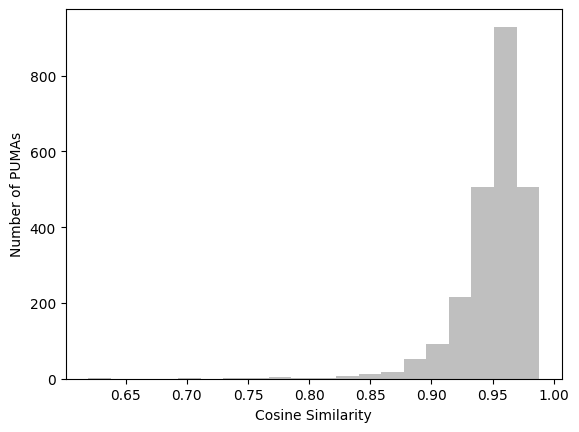

In [9]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

A = pums_hist.to_numpy()
B = hist_new.to_numpy()
cos = np.sum(A*B, axis=1)/(norm(A, axis=1)*norm(B, axis=1))

plt.hist(cos, 20, alpha=0.5, color='grey')
plt.xlabel('Cosine Similarity')
plt.ylabel('Number of PUMAs')
plt.savefig('sim.eps', bbox_inches='tight', pad_inches=0.05) 

print('Proportion higher than 0.95: ', np.count_nonzero(cos > 0.95) / len(cos))